### Create the data

In [3]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [4]:
from res.plot_lib import plot_data, plot_model, set_default

In [5]:
set_default()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
#C = 7
H = 100  # num_hidden_units (for the hidden layer of the model later)
# Note. H put in this cell to facilitate future tweaking.

**(?1)**
Does it mean that we may modify the value of `C` to have, say, `C=9`, 9 spirals?<br>
**(R1)** Yes, it means so.

The next cell will draw three spirals (parametrized curves) (plus some noise)

$$
  t \mapsto {}t\,(\sin\theta, \cos\theta)
$$

where
$
  t \in [0,1],\;
  \theta = 2\pi\frac{2}{C} t + 2\pi\frac{c}{C},\;
  c = 0,1,2,\;
  C = 3\,.
$
---
In other words, three spirals starting at angle $0, 2\pi\times\frac{1}{3}, 2\pi\times \frac{2}{3}$, resp., each sweeping an angle range of $2\pi\times\frac{2}{3}\,\text{(radian)}$.

In [13]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # This inner_var is to be put inside sin() and cos().
    inner_var = torch.linspace(
        (2 * math.pi / C) * (c),
        (2 * math.pi / C) * (2 + c),
        # why +2? Because that's when t = 1
        N
    ) + torch.randn(N) * 0.2
    #) + torch.randn(N) * 0.002
    # spiral plus some noise.
    # Try alter the noise to see if you indeed get spirals
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
            ## N.B. The above line is (sin, cos) instead of (cos, sin).
            ## It's helpful to note that (sin, cos) is like reverse the
            ## roles of x-axis and y-axis. (Try the next line instead.)
            #math.cos(inner_var[index]), math.sin(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


We could have, instead of defining inner_var that way, defined it like <br>
**`inner_var = t * (2 * math.pi / C) + (2 * math.pi / C) * c`**<br>

- These two definitions are _mathematically equivalent_.
- However, defining `inner_var` like we did before makes things faster because it requires less computations.

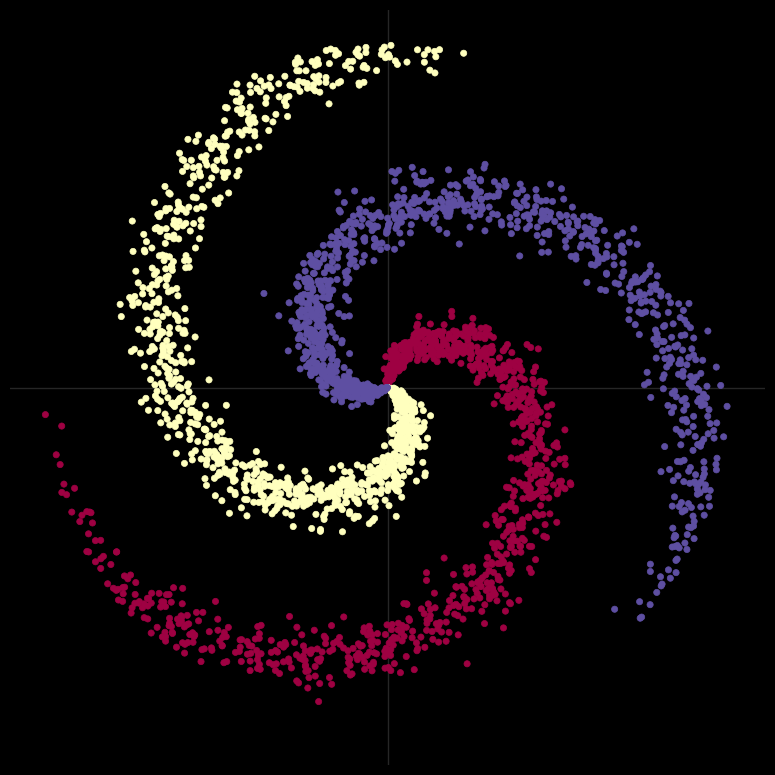

In [14]:
# visualise the data
plot_data(X, y)

**(?2)**
What's the diff btw `torch.Tensor` and `torch.FloatTensor`?

In [47]:
# not helping
torch.FloatTensor?

Init signature: torch.FloatTensor(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/.config/miniconda3/envs/pDL/lib/python3.8/site-packages/torch/__init__.py
Type:           tensortype
Subclasses:     


### Linear model

In [15]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [18]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA if there is CUDA on the machine

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t+1, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 1000, [LOSS]: 0.871362, [ACCURACY]: 0.505


Note that
- `y` consists of `0, 1, 2` and has `shape` equal to `(C*N, 1)`
- `y_pred` is the output of an affine transformation. In particular, its values is not bounded.
  (Note that we did not apply a softmax function.) `y_pred.shape` equals `(C*N, C)`
- They are put into `loss = criterion(y_pred, y)` which seems to be smart enough to deal
  with their difference
- **(?2)** `score, predicted = torch.max(y_pred, 1)` means
  that `torch.max` returns both `max` and `argmax`?
  Note that we did not use `score` in the above code cell.
- learned a new trick: `display.clear_output(wait=True)`


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


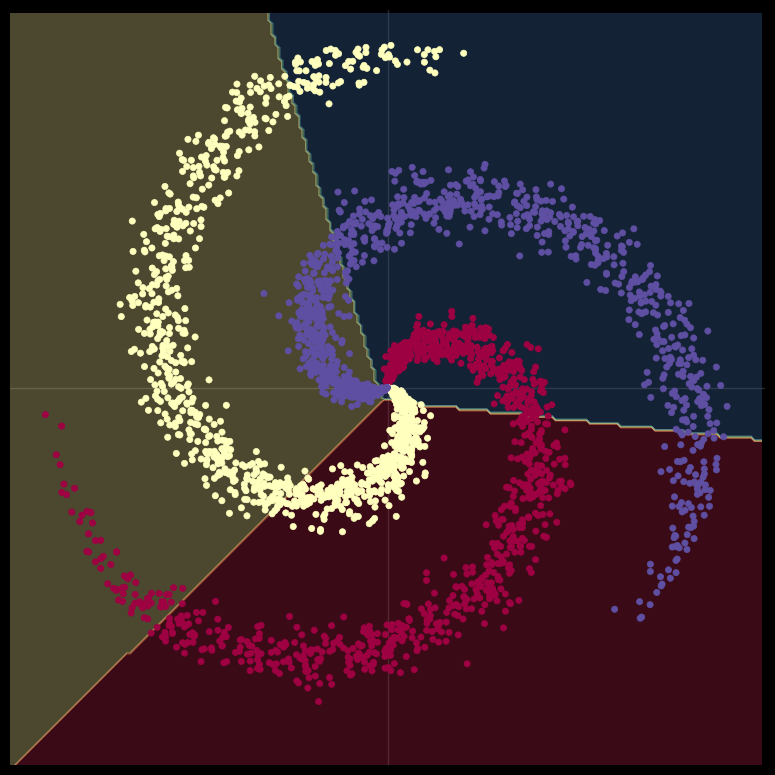

In [19]:
# Plot trained model
print(model)
plot_model(X, y, model)

**(?)** Alfredo asked an interesting question in the class: Can you tell what the `LOSS` is right at the beginning of the training?

**(R)** Try execute the next cell many times to have an imperical idea of what the answer might be. The times I tried, the `Loss` is constantly close to more or less **`1.11`**.

In [154]:
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

for t in range(1):
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    print(f"(epoch {t:04d}) loss = {loss}")

(epoch 0000) loss = 1.111934781074524


In `nn.Linear`, the weight's and bias's entries are randomly sampled from
uniform distribution $U(-\sqrt{k}, \sqrt{k})\,,$
where $k = \frac{1}{\texttt{# input features}}\,.$



- <https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html>

### Two-layered network

- **stopped here (2020/12/20 22h10)**
- **stopped here (2021/06/23 23h06)**

In [51]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [52]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.178407, [ACCURACY]: 0.949


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


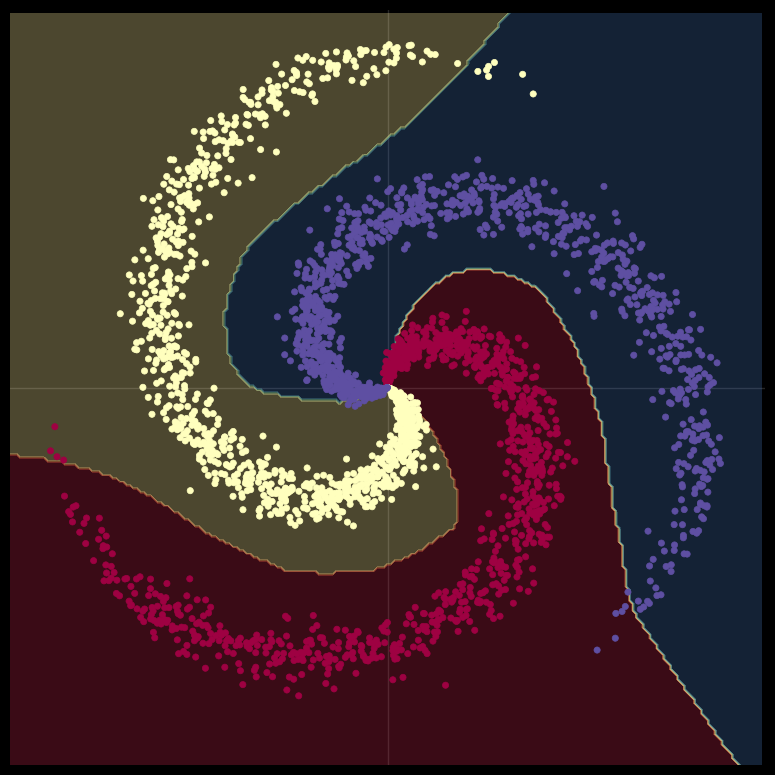

In [53]:
# Plot trained model
print(model)
plot_model(X, y, model)

- Try modify the number of neurons in each hidden layer and see what happens.

## Q & A

**(?)**
Explain a little bit `weight_decay=lambda_l2`.

**(?)**
`score, predicted = torch.max(y_pred, 1)`? What returns `torch.max()`?

`max(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)`
returns the 
- **max values**
- and **argmax indices**

If only one argument is given, i.e. no `dim`, e.g. `max(input)`, then **argmax indices** are not given.

In [56]:
a = torch.randn(4, 4)
a

tensor([[-1.2287,  0.2920,  0.4193, -2.7318],
        [ 0.7188,  0.2585, -0.1823,  0.9401],
        [ 1.3508, -0.2239,  0.1070,  2.9358],
        [-0.2769,  0.1217,  0.2951, -2.4135]])

In [57]:
torch.max(a, 1)

torch.return_types.max(
values=tensor([0.4193, 0.9401, 2.9358, 0.2951]),
indices=tensor([2, 3, 3, 2]))

In [61]:
torch.max(a)

tensor(2.9358)

In [58]:
b = torch.Tensor([1,0,-1,-2])
b

tensor([ 1.,  0., -1., -2.])

In [59]:
torch.max(b)

tensor(1.)

In [60]:
torch.max(b, 0)

torch.return_types.max(
values=tensor(1.),
indices=tensor(0))

**(?)**
`display.clear_output(wait=True)`

**(?)** 
> "_zero the gradients before running the backward pass_"

In [1]:
torch.manual_seed?

Object `torch.manual_seed` not found.


### `dtype` in `torch`

In [3]:
torch.zeros?

Object `torch.zeros` not found.


In [ ]:
torch.zeros(1).dtype